# Notebook for the extension of the project

This note book is the extension part of the project of the cource Advanced Machine Learning teached at Politecnico di Torino.

In this notebook we create a simulated a real-life application of quality control in a production line. The products that are in distribution are products that are produced correctly. While products that are out of distribution is assumed to be defect.

We used code and data from the 3DOS paper and the OpenShape paper

Open shape:
@misc{liu2023openshape,
      title={OpenShape: Scaling Up 3D Shape Representation Towards Open-World Understanding},
      author={Minghua Liu and Ruoxi Shi and Kaiming Kuang and Yinhao Zhu and Xuanlin Li and Shizhong Han and Hong Cai and Fatih Porikli and Hao Su},
      year={2023},
      eprint={2305.10764},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}

3DOS:
@inproceedings{
alliegro2022towards,
title={Towards Open Set 3D Learning: Benchmarking and Understanding Semantic Novelty Detection on Pointclouds},
author={Antonio Alliegro and Francesco Cappio Borlino and Tatiana Tommasi},
booktitle={Thirty-sixth Conference on Neural Information Processing Systems Datasets and Benchmarks Track},
year={2022},
url={https://openreview.net/forum?id=X2dHozbd1at}
}

# Clone git repos to environment

In [ ]:

!git clone https://github.com/Colin97/OpenShape_code.git
# Make sure you have git-lfs installed (https://git-lfs.com)
!git lfs install
!git clone https://huggingface.co/spaces/OpenShape/openshape-demo

# if you want to clone without large files – just their pointers
# prepend your git clone with the following env var:
!GIT_LFS_SKIP_SMUDGE=1
#!pip install -e .
!git clone https://huggingface.co/OpenShape/openshape-demo-support


Cloning into 'OpenShape_code'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 119 (delta 31), reused 12 (delta 12), pack-reused 80
Receiving objects: 100% (119/119), 3.45 MiB | 7.95 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Git LFS initialized.
Cloning into 'openshape-demo'...
remote: Enumerating objects: 188, done.
remote: Total 188 (delta 0), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (188/188), 1.43 MiB | 5.42 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Cloning into 'openshape-demo-support'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 102 (delta 9), reused 0 (delta 0), pack-reused 83
Receiving objects: 100% (102/102), 28.53 KiB | 9.51 MiB/s, done.
Resolving deltas: 100% (56/56), done.


# Install dependencies
Most dependencies are already satisfied by default in google colab

In [ ]:
!pip install huggingface_hub wandb omegaconf torch_redstone einops tqdm open3d dgl timm
!pip install --upgrade https://github.com/unlimblue/KNN_CUDA/releases/download/0.2/KNN_CUDA-0.2-py3-none-any.whl


# Log in to Huggingface

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from huggingface_hub import login
login()

# Get the OpenShape model from Huggingface

In [ ]:
%cd /content/openshape-demo-support
!pip install -e .
%cd /content

/content/openshape-demo-support
Obtaining file:///content/openshape-demo-support
  Preparing metadata (setup.py) ... done
  Attempting uninstall: openshape
    Found existing installation: openshape 0.1
    Uninstalling openshape-0.1:
      Successfully uninstalled openshape-0.1
  Running setup.py develop for openshape
/content


In [ ]:
import openshape
model = openshape.load_pc_encoder('openshape-pointbert-vitg14-rgb')


model.eval()

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.pt:   0%|          | 0.00/388M [00:00<?, ?B/s]

Projected(
  (ppat): PointPatchTransformer(
    (sa): PointNetSetAbstraction(
      (mlp_convs): ModuleList(
        (0): Conv2d(9, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (mlp_bns): ModuleList(
        (0-1): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lift): Sequential(
      (0): Conv1d(259, 512, kernel_size=(1,), stride=(1,))
      (1): Lambda()
      (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (transformer): Transformer(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout):

# Function for fitting pointclouds to input dimentions for OpenShape

In [ ]:
import numpy as np
import open3d as o3d
import random
import torch
from OpenShape_code.src.utils.data import normalize_pc

def load_ply(file_name, num_points=10000, y_up=True):
    pcd = o3d.io.read_point_cloud(file_name)  # Read the point cloud
    xyz = np.asarray(pcd.points)  # Get xyz coordinates
    rgb = np.asarray(pcd.colors)  # Get rgb colors
    n = xyz.shape[0]

    # Sample num_points points if necessary
    if n > num_points:
        idx = random.sample(range(n), num_points)
        xyz = xyz[idx]
        rgb = rgb[idx]
    elif n < num_points:
        print(f"Warning: requested {num_points} points, but file has only {n} points.", file=sys.stderr)

    # Adjust orientation by swapping y and z if requested
    if y_up:
        xyz[:, [1, 2]] = xyz[:, [2, 1]]

    # Normalize the point cloud coordinates
    xyz_normalized = normalize_pc(xyz)

    # Handle cases where rgb might be missing
    if rgb.size == 0:
        rgb = np.ones_like(xyz_normalized) * 0.4  # Default to a constant color if missing

    # Concatenate xyz with rgb
    features = np.concatenate([xyz_normalized, rgb], axis=1)

    # Convert to PyTorch tensors
    xyz_tensor = torch.from_numpy(xyz_normalized).float()
    features_tensor = torch.from_numpy(features).float()

    # Add batch dimention to fit as single input to OpenShape model
    features_tensor = features_tensor.unsqueeze(0)  # Adds a batch dimension, making it [1, N, 6]
    features_tensor = features_tensor.transpose(1, 2)  # Transposes to get [1, 6, N], matching the expected [B, C, N] format

    # Returning tensors instead of ME-specific batched coordinates
    return xyz_tensor, features_tensor

def filter_for_OpenShape(pointcloud, num_points=10000, y_up=True):
    xyz = np.asarray(pointcloud.points)  # Get xyz coordinates
    rgb = np.asarray(pointcloud.colors)  # Get rgb colors
    n = xyz.shape[0]

    # Sample num_points points if necessary
    if n > num_points:
        idx = random.sample(range(n), num_points)
        xyz = xyz[idx]
        #rgb = rgb[idx]
    elif n < num_points:
        print(f"Warning: requested {num_points} points, but file has only {n} points.", file=sys.stderr)

    # Adjust orientation by swapping y and z if requested
    if y_up:
        xyz[:, [1, 2]] = xyz[:, [2, 1]]

    # Normalize the point cloud coordinates
    xyz_normalized = normalize_pc(xyz)

    # Handle cases where rgb might be missing
    if rgb.size == 0:
        rgb = np.ones_like(xyz_normalized) * 0.4  # Default to a constant color if missing

    # Concatenate xyz with rgb
    features = np.concatenate([xyz_normalized, rgb], axis=1)

    # Convert to PyTorch tensors
    xyz_tensor = torch.from_numpy(xyz_normalized).float()
    features_tensor = torch.from_numpy(features).float()

    # Add batch dimention to fit as single input to OpenShape model
    features_tensor = features_tensor.unsqueeze(0)  # Adds a batch dimension, making it [1, N, 6]
    features_tensor = features_tensor.transpose(1, 2)  # Transposes to get [1, 6, N], matching the expected [B, C, N] format

    # Returning tensors instead of ME-specific batched coordinates
    return xyz_tensor, features_tensor


# Test that installation and environment works

If a feature vector is printed it should all be A OK!

In [ ]:
xyz, feat = load_ply("/content/OpenShape_code/demo/owl.ply")

device = torch.device("cpu")
model = model.to(device)
feat = feat.to(device)

output = model.forward(feat)

print(output)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tensor([[-59.6862, -42.0450, -23.0063,  ..., -35.3005,  52.0684, -18.3623]],
       grad_fn=<AddmmBackward0>)


# Clone 3DOS repo

In [ ]:
# Clone 3D_OS repo from github
%cd /content
!git clone https://github.com/antoalli/3D_OS.git
!cd 3D_OS && chmod +x download_data.sh && ./download_data.sh
!pip install h5py protobuf lmdb msgpack-numpy ninja scikit-learn

/content
Cloning into '3D_OS'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 152 (delta 51), reused 142 (delta 44), pack-reused 0
Receiving objects: 100% (152/152), 129.35 KiB | 1.01 MiB/s, done.
Resolving deltas: 100% (51/51), done.
============Downloading ShapeNetCore resampled in 
--2024-02-18 14:10:08--  https://www.dropbox.com/s/oa3qbujpugw4d43/sncore_fps_4096.tar?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/oa3qbujpugw4d43/sncore_fps_4096.tar [following]
--2024-02-18 14:10:10--  https://www.dropbox.com/s/dl/oa3qbujpugw4d43/sncore_fps_4096.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc062cda794709603ab0d

# Test if dataloaders work

In [ ]:
# Test if the data loaders work
import plotly.graph_objects as go
import time

for i, (data, label) in enumerate(src_loader):
    if label == 0:
        points = data
        points = points.reshape(-1, 3)

        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)

        fig = go.Figure(
          data=[
              go.Scatter3d(
                x=points[:,0],
                y=points[:,1],
                z=points[:,2],
                mode='markers',
              )
          ],
          layout=dict(
                scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
          )
        )
        fig.show()
        time.sleep(1)


# Function for displaying point cloud

In [ ]:
def display_pointcloud(pointcloud):
    points = pointcloud.points

    fig = go.Figure(
      data=[
          go.Scatter3d(
            x=np.asarray(points)[:,0],
            y=np.asarray(points)[:,1],
            z=np.asarray(points)[:,2],
            mode='markers',
          )
      ],
      layout=dict(
            scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
      )
    )
    fig.show()
    time.sleep(1)

# Create data for chair

We use a 3D chair downloaded from:

https://free3d.com/3d-model/office-chair-871087.html




In [ ]:
!pip install bpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.1/390.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 30.2 MB/s eta 0:00:00


In [ ]:
import numpy as np

def obj_to_pointcloud(obj_file_path, num_samples=10000):
    vertices = []
    with open(obj_file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):
                parts = line.strip().split()
                vertices.append([float(parts[1]), float(parts[2]), float(parts[3])])

    vertices_array = np.array(vertices)

    if vertices_array.shape[0] < num_samples:
        raise ValueError(f"Not enough vertices to sample: {vertices_array.shape[0]} available, {num_samples} requested.")

    sampled_indices = np.random.choice(vertices_array.shape[0], size=num_samples, replace=False)
    sampled_vertices = vertices_array[sampled_indices]

    return sampled_vertices

obj_file_path = '/content/Office chair.obj'

try:
    point_cloud = obj_to_pointcloud(obj_file_path)
    output_file_path = 'output_point_cloud.npy'
    np.save(output_file_path, point_cloud)
    print(f"Sampled point cloud saved to {output_file_path}")
except ValueError as e:
    print(e)

Sampled point cloud saved to output_point_cloud.npy


# Create dataset of correctly produced chairs
To get realistic measurements we add gaussian noise to the point cloud to simulate measurement noise.

In [ ]:
import open3d as o3d
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, random_split

class PointCloudDatasetWithLabels(Dataset):
    def __init__(self, point_clouds, labels):
        """
        Args:
            point_clouds (list): List of point clouds, each point cloud is a numpy array or PyTorch tensor.
            labels (list): List of labels corresponding to each point cloud.
        """
        assert len(point_clouds) == len(labels), "Point clouds and labels must have the same length"
        self.point_clouds = [torch.tensor(pc, dtype=torch.float) if not torch.is_tensor(pc) else pc for pc in point_clouds]
        self.labels = labels

    def __len__(self):
        return len(self.point_clouds)

    def __getitem__(self, idx):
        return self.point_clouds[idx], self.labels[idx]

def add_gaussian_noise_to_pointcloud(pcd, mean=0, std_dev=0.01):
    points = np.asarray(pcd.points)

    noise = np.random.normal(mean, std_dev, points.shape)

    noisy_points = points + noise

    noisy_pcd = o3d.geometry.PointCloud()
    noisy_pcd.points = o3d.utility.Vector3dVector(noisy_points)

    return noisy_pcd

def generate_noisy_chairs(pointcloud, number_of_noisy_chairs=100):
    noisy_chairs = []
    for i in range(0, number_of_noisy_chairs):
        noisy_pcd = add_gaussian_noise_to_pointcloud(pointcloud)
        noisy_chairs.append(noisy_pcd)
    return noisy_chairs


points = np.load("/content/output_point_cloud.npy")
points = torch.from_numpy(points)
print(points.shape)
points = points.reshape(-1, 3)
print(points.shape)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

noisy_chairs = generate_noisy_chairs(pcd, number_of_noisy_chairs=600)
noisy_chairs_labels = []
for i in range(0, len(noisy_chairs)):
    _, noisy_chairs[i] = filter_for_OpenShape(noisy_chairs[i], num_points=10000)
    noisy_chairs_labels.append(1)

# Assuming `point_cloud_list` is your list of point cloud inputs
noisy_correct_chairs_dataset = PointCloudDatasetWithLabels(noisy_chairs, noisy_chairs_labels)

# Create a DataLoader
noisy_correct_chairs_dataloader = DataLoader(noisy_correct_chairs_dataset, batch_size=4, shuffle=False, num_workers=2)

total_size = len(noisy_correct_chairs_dataset)
train_size = int(total_size * 0.5)  # 80% of the total size
test_size = total_size - train_size  # The rest for testing/validation

# Perform the split
train_dataset, id_dataset = random_split(noisy_correct_chairs_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
id_loader = DataLoader(id_dataset, batch_size=1, shuffle=False)


torch.Size([10000, 3])
torch.Size([10000, 3])


# Create dataset of defect chairs

In [ ]:
import open3d as o3d
import numpy as np
import random


# Localized Distortion
def distort_chair(chair_points):
    max_values = np.amax(chair_points, axis=0)
    x_max, y_max, z_max = max_values[0], max_values[1], max_values[2]

    min_values = np.amin(chair_points, axis=0)
    x_min, y_min, z_min = min_values[0], min_values[1], min_values[2]

    min_bound = np.array([x_min, y_min, z_min])
    max_bound = np.array([x_max, y_max, z_max])
    region_indices = np.all((chair_points >= min_bound) & (chair_points <= max_bound), axis=1)
    chair_points[region_indices] += np.random.normal(0, 0.5, chair_points[region_indices].shape)
    return chair_points

# Missing parts
def remove_points_from_chair(chair_points):
    num_missing_points = 100
    missing_indices = np.random.choice(len(chair_points), num_missing_points, replace=False)
    chair_points = np.delete(chair_points, missing_indices, axis=0)
    return chair_points

def remove_points_within_radius(point_cloud, radius):
    random_index = np.random.randint(len(point_cloud))
    random_point = point_cloud[random_index]

    squared_distances = np.sum((point_cloud - random_point) ** 2, axis=1)
    squared_radius = radius ** 2

    mask = squared_distances > squared_radius

    return point_cloud[mask]

def add_random_points(chair_points, final_size=10000):
    size = len(chair_points)
    points_to_add = final_size - size

    noise_indices = np.random.choice(len(chair_points), points_to_add, replace=False)
    new_points = chair_points[noise_indices] + np.random.normal(0, 0.1, chair_points[noise_indices].shape)

    return np.concatenate((chair_points, new_points), axis=0)

# Scale some parts
def scale_chair(chair_points, scale):
    scale_factor = scale
    chair_points *= scale_factor
    return chair_points

def add_noise_to_chair(chair_points, std = 10):
    noise_indices = np.random.choice(len(chair_points), 10, replace=False)
    chair_points[noise_indices] += np.random.normal(0, std, chair_points[noise_indices].shape)
    return chair_points

# Make chair asymmertric
def make_chair_asymmetric(chair_points):
    asymmetry_indices = chair_points[:, 0] > np.mean(chair_points[:, 0])  # For example, right half
    chair_points[asymmetry_indices] *= np.array([1.0, 0.9, 0.9])  # Scale down y and z
    return chair_points


def apply_asymmetrical_scaling(point_cloud, scale_factors=np.array([1.0, 0.9, 0.9])):
    axis = np.random.choice([0, 1, 2])

    median_value = np.median(point_cloud[:, axis])

    if np.random.rand() > 0.5:
        selected_half_mask = point_cloud[:, axis] > median_value
    else:
        selected_half_mask = point_cloud[:, axis] <= median_value

    point_cloud[selected_half_mask] *= np.array(scale_factors)

    return point_cloud


def random_rotation_matrix():
    """Generate a random rotation matrix."""
    theta = np.random.uniform(0, 2 * np.pi)

    axis = np.random.randn(3)
    axis = axis / np.linalg.norm(axis)

    K = np.array([[0, -axis[2], axis[1]],
                  [axis[2], 0, -axis[0]],
                  [-axis[1], axis[0], 0]])
    rotation_matrix = np.eye(3) + np.sin(theta) * K + (1 - np.cos(theta)) * np.dot(K, K)

    return rotation_matrix

def create_random_defect(pcd, type_of_defect):
    chair_points = np.asarray(pcd.points)

    if type_of_defect == "distort":
        chair_points = distort_chair(chair_points)
    elif type_of_defect == "remove parts":
        chair_points = remove_points_within_radius(chair_points, 300)
        chair_points = add_random_points(chair_points)
    elif type_of_defect == "scale":
        chair_points = scale_chair(chair_points, scale=random.uniform(0.8, 1.3))
    elif type_of_defect == "add noise":
        chair_points = add_noise_to_chair(chair_points)
    elif type_of_defect == "asymmetrical":
        rotation_matrix = random_rotation_matrix()
        rotation_matrix_inv = rotation_matrix.T
        chair_points = np.dot(chair_points, rotation_matrix.T)
        chair_points = apply_asymmetrical_scaling(chair_points, scale_factors=np.array([1.0, 0.8, 0.8]))
        chair_points = np.dot(chair_points, rotation_matrix_inv.T)

    defect_pcd = o3d.geometry.PointCloud()
    defect_pcd.points = o3d.utility.Vector3dVector(chair_points)
    return defect_pcd

def generate_defect_chairs(pointcloud, type_of_defects, number_of_noisy_chairs=100):
    defect_chairs = []
    num_each_type = number_of_noisy_chairs //len(type_of_defects)
    for defect in type_of_defects:
        for i in range(0, num_each_type):
            # Add defect
            defect_pcd = create_random_defect(pcd, defect)
            # Add measurement noise
            defect_pcd = add_gaussian_noise_to_pointcloud(defect_pcd, mean=0, std_dev=0.01)
            defect_chairs.append(defect_pcd)
    return defect_chairs

type_of_defects = ["distort", "remove parts", "scale", "add noise", "asymmetrical"]
defect_chairs = generate_defect_chairs(pcd, type_of_defects, number_of_noisy_chairs=500)
defect_chairs_labels = np.zeros(len(defect_chairs))
for i in range(0, len(defect_chairs)):
    _, defect_chairs[i] = filter_for_OpenShape(defect_chairs[i], num_points=10000)

# Assuming `point_cloud_list` is your list of point cloud inputs
noisy_defect_chairs_dataset = PointCloudDatasetWithLabels(defect_chairs, defect_chairs_labels)

# Create a DataLoader
ood_loader = DataLoader(noisy_defect_chairs_dataset, batch_size=1, shuffle=False, num_workers=2)


In [ ]:
# Iterate through the DataLoader
for data in train_loader:
    print("train_loader")
    if isinstance(data, tuple) or isinstance(data, list):
        inputs, targets = data
        print(f"Input batch dimensions: {inputs.shape}")
        print(f"Target batch dimensions: {targets.shape}")
    else:
        # If there are no targets/labels
        print(f"Input batch dimensions: {data.shape}")
    break  # Break after the first batch to just check the dimensions

# Iterate through the DataLoader
for data in id_loader:
    print("id_loader")
    if isinstance(data, tuple) or isinstance(data, list):
        inputs, targets = data
        print(f"Input batch dimensions: {inputs.shape}")
        print(f"Target batch dimensions: {targets.shape}")
    else:
        # If there are no targets/labels
        print(f"Input batch dimensions: {data.shape}")
    break  # Break after the first batch to just check the dimensions

# Iterate through the DataLoader
for data in ood_loader:
    print("ood_loader")
    if isinstance(data, tuple) or isinstance(data, list):
        inputs, targets = data
        print(f"Input batch dimensions: {inputs.shape}")
        print(f"Target batch dimensions: {targets.shape}")
    else:
        # If there are no targets/labels
        print(f"Input batch dimensions: {data.shape}")
    break  # Break after the first batch to just check the dimensions

train_loader
Input batch dimensions: torch.Size([1, 1, 6, 10000])
Target batch dimensions: torch.Size([1])
id_loader
Input batch dimensions: torch.Size([1, 1, 6, 10000])
Target batch dimensions: torch.Size([1])
ood_loader
Input batch dimensions: torch.Size([1, 1, 6, 10000])
Target batch dimensions: torch.Size([1])


# Run data through the OpenShape model

In [ ]:
# Run data through OpenShape
from tqdm import tqdm
device = torch.device("cpu")
model = model.to(device)

%cd /content
save_dir = "Extension_outputs"
if not os.path.exists(save_dir):
    print(f"Creating directory: {save_dir}")
    os.makedirs(save_dir)

print("Running training data through the OpenShape model")
train_feats = []
for i, (data, label) in tqdm(enumerate(train_loader)):

    data = data.to(device)

    output_feat = model.forward(feat)

    train_feats.append(output_feat.detach().numpy())

outfile = save_dir + "/train_feats.npy"
np.save(outfile, np.array(train_feats))
print("Saved data to " + outfile)

/content
Running training data through the OpenShape model


500it [06:15,  1.33it/s]

Saved data to Extension_outputs/train_feats.npy


In [ ]:


print("Running ID data through the OpenShape model")
src_feats = []
for i, (data, label) in tqdm(enumerate(id_loader)):
    points = data
    points = points.reshape(-1, 3)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    xyz, feat = filter_for_OpenShape(pcd)
    feat = feat.to(device)

    output_feat = model.forward(feat)

    src_feats.append(output_feat.detach().numpy())

outfile = save_dir + "/src_feats"
np.save(outfile, np.array(src_feats))
print("Saved data to " + outfile)



Running ID data through the OpenShape model


500it [08:36,  1.03s/it]

Saved data to Extension_outputs/src_feats


In [ ]:

print("Rinning OOD1 data throug the OpenShape model")
ood_feats = []
for i, (data, label) in tqdm(enumerate(ood_loader)):
    points = data
    points = points.reshape(-1, 3)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    xyz, feat = filter_for_OpenShape(pcd)
    feat = feat.to(device)

    output_feat = model.forward(feat)

    ood_feats.append(output_feat.detach().numpy())

outfile = save_dir + "/ood_feats"
np.save(outfile, np.array(ood_feats))
print("Saved data to " + outfile)

Rinning OOD1 data throug the OpenShape model


500it [08:48,  1.06s/it]

Saved data to Extension_outputs/ood_feats


In [ ]:
train_feats = np.load("Extension_outputs/train_feats.npy")
id_feats = np.load("Extension_outputs/src_feats.npy")
ood_feats = np.load("Extension_outputs/ood_feats.npy")

train_feats = torch.from_numpy(train_feats)
id_feats = torch.from_numpy(id_feats)
ood_feats = torch.from_numpy(ood_feats)

In [ ]:
print(train_feats.shape)
print(id_feats.shape)
print(ood_feats.shape)

torch.Size([500, 1, 1280])
torch.Size([500, 1, 1280])
torch.Size([500, 1, 1280])


In [ ]:

from knn_cuda import KNN
knn = KNN(k=1, transpose_mode=True)

device = torch.device("cuda")
train_feats = train_feats.to(device)
src_feats = id_feats.to(device)
tar1_feats = ood_feats.to(device)

################################################
print("Euclidean distances in a non-normalized space:")
# eucl distance in a non-normalized space
src_dist, src_ids = knn(train_feats.unsqueeze(0), src_feats.unsqueeze(0))
src_dist = src_dist.squeeze().cpu()
src_ids = src_ids.squeeze().cpu()  # index of nearest training sample
src_scores = 1 / src_dist
#src_pred = np.asarray([train_labels[i] for i in src_ids])  # pred is label of nearest training sample

# OOD tar1
tar1_dist, _ = knn(train_feats.unsqueeze(0), tar1_feats.unsqueeze(0))
tar1_dist = tar1_dist.squeeze().cpu()
tar1_scores = 1 / tar1_dist


eval_ood_sncore(
    scores_list=[src_scores, tar1_scores, tar1_scores],
    preds_list=[None, None, None],  # [src_pred, None, None],
    labels_list=[None, None, None],  # [src_labels, None, None],
    src_label=1  # confidence should be higher for ID samples
)

print(src_scores)


Euclidean distances in a non-normalized space:
AUROC - Src label: 1, Tar label: 0
SRC->TAR1:      AUROC: 0.4796, FPR95: 0.9540, AUPR_IN: 0.4941, AUPR_OUT: 0.4916
SRC->TAR2:      AUROC: 0.4796, FPR95: 0.9540, AUPR_IN: 0.4941, AUPR_OUT: 0.4916
SRC->TAR1+TAR2: AUROC: 0.4796, FPR95: 0.9540, AUPR_IN: 0.3287, AUPR_OUT: 0.6581
to spreadsheet: 0.47958,0.954,0.49412373666884696,0.49163684122479717,0.47958,0.954,0.49412373666884696,0.49163684122479717,0.47958,0.954,0.3287227001531896,0.6581006733539576


(-1,
 -1,
 {'fpr_at_95_tpr': 0.954,
  'detection_error': 0.496,
  'auroc': 0.47958,
  'aupr_in': 0.49412373666884696,
  'aupr_out': 0.49163684122479717},
 {'fpr_at_95_tpr': 0.954,
  'detection_error': 0.496,
  'auroc': 0.47958,
  'aupr_in': 0.49412373666884696,
  'aupr_out': 0.49163684122479717},
 {'fpr_at_95_tpr': 0.954,
  'detection_error': 0.33066666666666666,
  'auroc': 0.47958,
  'aupr_in': 0.3287227001531896,
  'aupr_out': 0.6581006733539576})

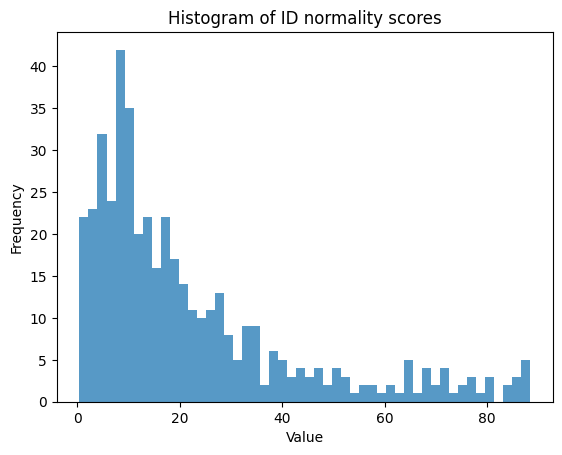

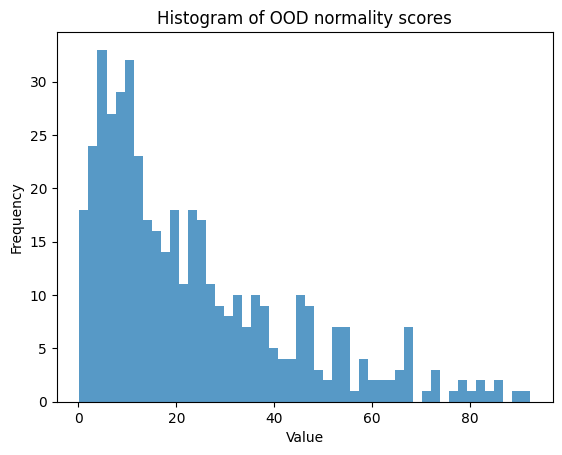

In [ ]:
import matplotlib.pyplot as plt

# Example tensor
data = src_scores

# Convert to numpy for percentile calculation
data_np = data.numpy()

# Calculate Q1 and Q3
Q1 = np.percentile(data_np, 25)
Q3 = np.percentile(data_np, 75)

# Calculate the IQR
IQR = Q3 - Q1

# Determine the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Convert bounds back to PyTorch tensors for comparison (optional)
lower_bound_tensor = torch.tensor(lower_bound)
upper_bound_tensor = torch.tensor(upper_bound)

# Filter out outliers
filtered_data = data[(data >= lower_bound_tensor) & (data <= upper_bound_tensor)]


# Plot histogram
plt.hist(filtered_data, bins=50, alpha=0.75)  # Adjust the number of bins as needed

plt.title('Histogram of ID normality scores')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

# Example tensor
data = tar1_scores

# Convert to numpy for percentile calculation
data_np = data.numpy()

# Calculate Q1 and Q3
Q1 = np.percentile(data_np, 25)
Q3 = np.percentile(data_np, 75)

# Calculate the IQR
IQR = Q3 - Q1

# Determine the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Convert bounds back to PyTorch tensors for comparison (optional)
lower_bound_tensor = torch.tensor(lower_bound)
upper_bound_tensor = torch.tensor(upper_bound)

# Filter out outliers
filtered_data = data[(data >= lower_bound_tensor) & (data <= upper_bound_tensor)]

# Plot histogram
plt.hist(filtered_data, bins=50, alpha=0.75)  # Adjust the number of bins as needed

plt.title('Histogram of OOD normality scores')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()


In [ ]:
# Run this command to save data to google drive
!cp -r /content/Extension_outputs "/content/drive/MyDrive/Skole/Advanced machine learning project"

# Finding out how defect a chair needs to be for our approach to work


In [ ]:
# Load chair
points = np.load("/content/output_point_cloud.npy")
points = torch.from_numpy(points)
points = points.reshape(-1, 3)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Create a defect point cloud
number_of_samples_per_defect = 300
type_of_defects = ["distort", "remove parts", "scale", "add noise", "asymmetrical"]
defect_chairs_distort = generate_defect_chairs(pcd, ["distort"], number_of_noisy_chairs=number_of_samples_per_defect)
defect_chairs_remove_parts = generate_defect_chairs(pcd, ["remove parts"], number_of_noisy_chairs=number_of_samples_per_defect)
defect_chairs_scale = generate_defect_chairs(pcd, ["scale"], number_of_noisy_chairs=number_of_samples_per_defect)
defect_chairs_add_noise = generate_defect_chairs(pcd, ["add noise"], number_of_noisy_chairs=number_of_samples_per_defect)
defect_chairs_asymmetrical = generate_defect_chairs(pcd, ["asymmetrical"], number_of_noisy_chairs=number_of_samples_per_defect)

# Create labels
defect_chairs_distort_labels = ["distort"] * number_of_samples_per_defect
defect_chairs_remove_parts_labels = ["remove parts"] * number_of_samples_per_defect
defect_chairs_scale_labels = ["scale"] * number_of_samples_per_defect
defect_chairs_add_noise_labels = ["add noise"] * number_of_samples_per_defect
defect_chairs_asymmetrical_labels = ["asymmetrical"] * number_of_samples_per_defect

# Filter for OpenShape
for i in range(0, number_of_samples_per_defect):
    _, defect_chairs_distort[i] = filter_for_OpenShape(defect_chairs_distort[i], num_points=10000)
    _, defect_chairs_remove_parts[i] = filter_for_OpenShape(defect_chairs_remove_parts[i], num_points=10000)
    _, defect_chairs_scale[i] = filter_for_OpenShape(defect_chairs_scale[i], num_points=10000)
    _, defect_chairs_add_noise[i] = filter_for_OpenShape(defect_chairs_add_noise[i], num_points=10000)
    _, defect_chairs_asymmetrical[i] = filter_for_OpenShape(defect_chairs_asymmetrical[i], num_points=10000)

# Create datasets
defect_chairs_distort_dataset = PointCloudDatasetWithLabels(defect_chairs_distort, defect_chairs_distort_labels)
defect_chairs_remove_parts_dataset = PointCloudDatasetWithLabels(defect_chairs_remove_parts, defect_chairs_remove_parts_labels)
defect_chairs_scale_dataset = PointCloudDatasetWithLabels(defect_chairs_scale, defect_chairs_scale_labels)
defect_chairs_add_noise_dataset = PointCloudDatasetWithLabels(defect_chairs_add_noise, defect_chairs_add_noise_labels)
defect_chairs_asymmetrical_dataset = PointCloudDatasetWithLabels(defect_chairs_asymmetrical, defect_chairs_asymmetrical_labels)

# Create dataloaders
defect_chairs_distort_loader = DataLoader(defect_chairs_distort_dataset, batch_size=1, shuffle=False, num_workers=2)
defect_chairs_remove_parts_loader = DataLoader(defect_chairs_remove_parts_dataset, batch_size=1, shuffle=False, num_workers=2)
defect_chairs_scale_loader = DataLoader(defect_chairs_scale_dataset, batch_size=1, shuffle=False, num_workers=2)
defect_chairs_add_noise_loader = DataLoader(defect_chairs_add_noise_dataset, batch_size=1, shuffle=False, num_workers=2)
defect_chairs_asymmetrical_loader = DataLoader(defect_chairs_asymmetrical_dataset, batch_size=1, shuffle=False, num_workers=2)


In [ ]:
from tqdm import tqdm
import os

device = torch.device("cpu")
model = model.to(device)

def run_data_through_model_and_save_data(dataloader, filename, save_dir):
    print("Running training data through the OpenShape model")
    feats = []
    for i, (data, label) in tqdm(enumerate(dataloader)):

        data = data.to(device)

        output_feat = model.forward(feat)

        feats.append(output_feat.detach().numpy())

    outfile = save_dir + "/" + filename + ".npy"
    np.save(outfile, np.array(feats))
    print("Saved data to " + outfile)
    return feats

%cd /content
save_dir = "Extension_outputs_with_different_distortions"
if not os.path.exists(save_dir):
    print(f"Creating directory: {save_dir}")
    os.makedirs(save_dir)


/content


In [ ]:
# Run data through OpenShape

defect_chairs_distort_feats = run_data_through_model_and_save_data(defect_chairs_distort_loader, "defect_chairs_distort_feats", save_dir)
defect_chairs_remove_parts_feats = run_data_through_model_and_save_data(defect_chairs_remove_parts_loader, "defect_chairs_remove_parts_feats", save_dir)
defect_chairs_scale_feats = run_data_through_model_and_save_data(defect_chairs_scale_loader, "defect_chairs_scale_feats", save_dir)
defect_chairs_add_noise_feats = run_data_through_model_and_save_data(defect_chairs_add_noise_loader, "defect_chairs_add_noise_feats", save_dir)
defect_chairs_asymmetrical_feats = run_data_through_model_and_save_data(defect_chairs_asymmetrical_loader, "defect_chairs_asymmetrical_feats", save_dir)

In [ ]:
train_feats = run_data_through_model_and_save_data(train_loader, "train_feats", save_dir)
src_feats = run_data_through_model_and_save_data(id_loader, "src_feats", save_dir)

Running training data through the OpenShape model


300it [03:12,  1.56it/s]


Saved data to Extension_outputs_with_different_distortions/train_feats.npy
Running training data through the OpenShape model


300it [03:11,  1.57it/s]

Saved data to Extension_outputs_with_different_distortions/src_feats.npy


In [ ]:
train_feats = np.load("Extension_outputs_with_different_distortions/train_feats.npy")
src_feats = np.load("Extension_outputs_with_different_distortions/src_feats.npy")
defect_chairs_distort_feats = np.load("/content/Extension_outputs_with_different_distortions/defect_chairs_distort_feats.npy")
defect_chairs_remove_parts_feats = np.load("/content/Extension_outputs_with_different_distortions/defect_chairs_remove_parts_feats.npy")
defect_chairs_scale_feats = np.load("/content/Extension_outputs_with_different_distortions/defect_chairs_scale_feats.npy")
defect_chairs_add_noise_feats = np.load("/content/Extension_outputs_with_different_distortions/defect_chairs_add_noise_feats.npy")
defect_chairs_asymmetrical_feats = np.load("/content/Extension_outputs_with_different_distortions/defect_chairs_asymmetrical_feats.npy")

train_feats = torch.from_numpy(train_feats)
src_feats = torch.from_numpy(src_feats)
defect_chairs_distort_feats = torch.from_numpy(defect_chairs_distort_feats)
defect_chairs_remove_parts_feats = torch.from_numpy(defect_chairs_remove_parts_feats)
defect_chairs_scale_feats = torch.from_numpy(defect_chairs_scale_feats)
defect_chairs_add_noise_feats = torch.from_numpy(defect_chairs_add_noise_feats)
defect_chairs_asymmetrical_feats = torch.from_numpy(defect_chairs_asymmetrical_feats)

In [ ]:
# Evaluate model
from knn_cuda import KNN
%cd /content/3D_OS
from utils.ood_utils import eval_ood_sncore
%cd /content

knn = KNN(k=1, transpose_mode=True)

device = torch.device("cuda")
train_feats = train_feats.to(device)
src_feats = src_feats.to(device)
defect_chairs_distort_feats = defect_chairs_distort_feats.to(device)
defect_chairs_remove_parts_feats = defect_chairs_remove_parts_feats.to(device)
defect_chairs_scale_feats = defect_chairs_scale_feats.to(device)
defect_chairs_add_noise_feats = defect_chairs_add_noise_feats.to(device)
defect_chairs_asymmetrical_feats = defect_chairs_asymmetrical_feats.to(device)


def print_CeL2_scores(train_feats, src_feats, ood_feats):
    print("Euclidean distances in a non-normalized space:")
    # eucl distance in a non-normalized space
    src_dist, src_ids = knn(train_feats.unsqueeze(0), src_feats.unsqueeze(0))
    src_dist = src_dist.squeeze().cpu()
    src_scores = 1 / src_dist

    ood_dist, _ = knn(train_feats.unsqueeze(0), ood_feats.unsqueeze(0))
    ood_dist = ood_dist.squeeze().cpu()
    ood_scores = 1 / ood_dist

    # Scores for distort
    eval_ood_sncore(
        scores_list=[src_scores, ood_scores, ood_scores],
        preds_list=[None, None, None],  # [src_pred, None, None],
        labels_list=[None, None, None],  # [src_labels, None, None],
        src_label=1  # confidence should be higher for ID samples
    )
# Print scores
print("defect_chairs_distort_feats")
print_CeL2_scores(train_feats, src_feats, defect_chairs_distort_feats)
print("defect_chairs_remove_parts_feats")
print_CeL2_scores(train_feats, src_feats, defect_chairs_remove_parts_feats)
print("defect_chairs_scale_feats")
print_CeL2_scores(train_feats, src_feats, defect_chairs_scale_feats)
print("defect_chairs_add_noise_feats")
print_CeL2_scores(train_feats, src_feats, defect_chairs_add_noise_feats)
print("defect_chairs_asymmetrical_feats")
print_CeL2_scores(train_feats, src_feats, defect_chairs_asymmetrical_feats)


/content/3D_OS
/content
defect_chairs_distort_feats
Euclidean distances in a non-normalized space:
AUROC - Src label: 1, Tar label: 0
SRC->TAR1:      AUROC: 0.4790, FPR95: 0.9467, AUPR_IN: 0.4882, AUPR_OUT: 0.5013
SRC->TAR2:      AUROC: 0.4790, FPR95: 0.9467, AUPR_IN: 0.4882, AUPR_OUT: 0.5013
SRC->TAR1+TAR2: AUROC: 0.4790, FPR95: 0.9467, AUPR_IN: 0.3241, AUPR_OUT: 0.6657
to spreadsheet: 0.47897222222222224,0.9466666666666667,0.48822161066163655,0.5012799029528714,0.47897222222222224,0.9466666666666667,0.48822161066163655,0.5012799029528714,0.47897222222222224,0.9466666666666667,0.324128647097016,0.6657340558918867
defect_chairs_remove_parts_feats
Euclidean distances in a non-normalized space:
AUROC - Src label: 1, Tar label: 0
SRC->TAR1:      AUROC: 0.5221, FPR95: 0.9567, AUPR_IN: 0.5131, AUPR_OUT: 0.5242
SRC->TAR2:      AUROC: 0.5221, FPR95: 0.9567, AUPR_IN: 0.5131, AUPR_OUT: 0.5242
SRC->TAR1+TAR2: AUROC: 0.5221, FPR95: 0.9567, AUPR_IN: 0.3467, AUPR_OUT: 0.6868
to spreadsheet: 0.52208

# Testing the PointNet++ for the same task

In [ ]:
#@title JS Shell
%%html
<div id=term_demo></div>
<script src="https://code.jquery.com/jquery-latest.js"></script>
<script src="https://cdn.jsdelivr.net/npm/jquery.terminal/js/jquery.terminal.min.js"></script>
<link href="https://cdn.jsdelivr.net/npm/jquery.terminal/css/jquery.terminal.min.css" rel="stylesheet"/>
<script>
  $('#term_demo').terminal(function(command) {
      if (command !== '') {
          try {
              var result = window.eval(command);
              if (result !== undefined) {
                  this.echo(new String(result));
              }
          } catch(e) {
              this.error(new String(e));
          }
      } else {
          this.echo('');
      }
  }, {
      greetings: 'Welcome to JavaScript Shell',
      name: 'js_demo',
      height: 200,
      prompt: 'js> '
  });

from IPython.display import JSON
from google.colab import output
from subprocess import getoutput
import os

def shell(command):
  if command.startswith('cd'):
    path = command.strip().split(maxsplit=1)[1]
    os.chdir(path)
    return JSON([''])
  return JSON([getoutput(command)])
output.register_callback('shell', shell)

#@title Colab Shell
%%html
<div id=term_demo></div>
<script src="https://code.jquery.com/jquery-latest.js"></script>
<script src="https://cdn.jsdelivr.net/npm/jquery.terminal/js/jquery.terminal.min.js"></script>
<link href="https://cdn.jsdelivr.net/npm/jquery.terminal/css/jquery.terminal.min.css" rel="stylesheet"/>
<script>
  $('#term_demo').terminal(async function(command) {
      if (command !== '') {
          try {
              let res = await google.colab.kernel.invokeFunction('shell', [command])
              let out = res.data['application/json'][0]
              this.echo(new String(out))
          } catch(e) {
              this.error(new String(e));
          }
      } else {
          this.echo('');
      }
  }, {
      greetings: 'Welcome to Colab Shell',
      name: 'colab_demo',
      height: 250,
      prompt: 'colab > '
  });

# Create a PointNet model
Code from repo: https://github.com/fxia22/pointnet.pytorch.git

From paper:
Charles R Qi, Hao Su, Kaichun Mo, and Leonidas J Guibas. Pointnet: Deep learning on point
sets for 3d classification and segmentation. In Proceedings of the IEEE conference on computer
vision and pattern recognition, pages 652–660, 2017.

In [ ]:
!git clone https://github.com/fxia22/pointnet.pytorch.git

Cloning into 'pointnet.pytorch'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 213 (delta 0), reused 2 (delta 0), pack-reused 211
Receiving objects: 100% (213/213), 229.91 KiB | 1.21 MiB/s, done.
Resolving deltas: 100% (125/125), done.


# Create dataset

In [ ]:
import open3d as o3d
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, random_split

class PointCloudDatasetWithLabels(Dataset):
    def __init__(self, point_clouds, labels):
        """
        Args:
            point_clouds (list): List of point clouds, each point cloud is a numpy array or PyTorch tensor.
            labels (list): List of labels corresponding to each point cloud.
        """
        assert len(point_clouds) == len(labels), "Point clouds and labels must have the same length"
        self.point_clouds = [torch.tensor(pc, dtype=torch.float) if not torch.is_tensor(pc) else pc for pc in point_clouds]
        self.labels = labels

    def __len__(self):
        return len(self.point_clouds)

    def __getitem__(self, idx):
        return self.point_clouds[idx], self.labels[idx]

def add_gaussian_noise_to_pointcloud(pcd, mean=0, std_dev=0.01):
    points = np.asarray(pcd.points)

    noise = np.random.normal(mean, std_dev, points.shape)

    noisy_points = points + noise

    noisy_pcd = o3d.geometry.PointCloud()
    noisy_pcd.points = o3d.utility.Vector3dVector(noisy_points)

    return noisy_pcd

def generate_noisy_chairs(pointcloud, number_of_noisy_chairs=100):
    noisy_chairs = []
    for i in range(0, number_of_noisy_chairs):
        noisy_pcd = add_gaussian_noise_to_pointcloud(pointcloud)
        noisy_chairs.append(noisy_pcd)
    return noisy_chairs


points = np.load("/content/output_point_cloud.npy")
points = torch.from_numpy(points)
print(points.shape)
points = points.reshape(-1, 3)
print(points.shape)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

noisy_chairs = generate_noisy_chairs(pcd, number_of_noisy_chairs=600)
noisy_chairs_labels = []
for i in range(0, len(noisy_chairs)):
    _, noisy_chairs[i] = filter_for_OpenShape(noisy_chairs[i], num_points=10000)
    noisy_chairs_labels.append(6)

# Assuming `point_cloud_list` is your list of point cloud inputs
noisy_correct_chairs_dataset = PointCloudDatasetWithLabels(noisy_chairs, noisy_chairs_labels)

# Create a DataLoader
noisy_correct_chairs_dataloader = DataLoader(noisy_correct_chairs_dataset, batch_size=4, shuffle=False, num_workers=2)

total_size = len(noisy_correct_chairs_dataset)
train_size = int(total_size * 0.5)  # 80% of the total size
test_size = total_size - train_size  # The rest for testing/validation

# Perform the split
train_dataset, id_dataset = random_split(noisy_correct_chairs_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
id_loader = DataLoader(id_dataset, batch_size=1, shuffle=False)



In [ ]:
!pip install h5py protobuf lmdb msgpack-numpy ninja scikit-learn

In [ ]:
!pip install huggingface_hub wandb omegaconf torch_redstone einops tqdm open3d dgl timm
!pip install --upgrade https://github.com/unlimblue/KNN_CUDA/releases/download/0.2/KNN_CUDA-0.2-py3-none-any.whl

In [ ]:
# Change folder to 3D_OS to get the same dataloaders
%cd "/content/3D_OS"
!ls utils

import os

# Change this path to the root directory of the cloned repository
repo_root = '/content/3D_OS'

os.chdir(repo_root)
print("Current Working Directory:", os.getcwd())

import sys
import os
import warnings
import numpy as np

sys.path.append(os.getcwd())
import os.path as osp
import time
from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.utils import *
from utils.dist import *
# noinspection PyUnresolvedReferences
from utils.data_utils import H5_Dataset
#from datasets.modelnet import *
from datasets.scanobject import *
from models.classifiers import Classifier
from utils.ood_utils import get_confidence, eval_ood_sncore, iterate_data_odin, \
    iterate_data_energy, iterate_data_gradnorm, iterate_data_react, estimate_react_thres, print_ood_output, \
    get_penultimate_feats, get_network_output
import wandb
from base_args import add_base_args
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from models.common import convert_model_state, logits_entropy_loss
from models.ARPL_utils import Generator, Discriminator
from classifiers.common import train_epoch_cla, train_epoch_rsmix_exposure, train_epoch_cs
from classifiers.trainer_ddp_cla_md import get_args, load_yaml, get_md_eval_loaders

# Code from 3DOS repo classifiers/trainer_ddp_cla_md.py line 192-478

#  python -m torch.distributed.launch --nproc_per_node=1 Failure_Analysis/custom\
# tests/evaluating_PointNet_cosine_MLS.py --config cfgs/pn2-msg.yaml
# --exp_name PN2_cosine_SR1 --src SR1 --loss cosine -mode eval
# --ckpt_path outputs/PN2_cosine_SR1/models/model_best.pth


# Code from 3DOS repo classifiers/trainer_ddp_cla_md.py line 468-478
def eval_ood_md2sonn(opt, config):
    print(f"Arguments: {opt}")
    set_random_seed(opt.seed)

    dataloader_config = {
        'batch_size': opt.batch_size, 'drop_last': False, 'shuffle': False,
        'num_workers': opt.num_workers, 'sampler': None, 'worker_init_fn': init_np_seed}

    # whole evaluation is done on ScanObject RW data
    sonn_args = {
        'data_root': opt.data_root,
        'sonn_split': opt.sonn_split,
        'h5_file': opt.sonn_h5_name,
        'split': 'all',  # we use both training (unused) and test samples during evaluation
        'num_points': opt.num_points_test,  # default: use all 2048 sonn points to avoid sampling randomicity
        'transforms': None  # no augmentation applied at inference time
    }

    train_loader, _ = get_md_eval_loaders(opt)
    if opt.src == 'SR1':
        print("Src is SR1\n")
        id_loader = DataLoader(ScanObject(class_choice="sonn_2_mdSet1", **sonn_args), **dataloader_config)
        ood1_loader = DataLoader(ScanObject(class_choice="sonn_2_mdSet2", **sonn_args), **dataloader_config)
    elif opt.src == 'SR2':
        print("Src is SR2\n")
        id_loader = DataLoader(ScanObject(class_choice="sonn_2_mdSet2", **sonn_args), **dataloader_config)
        ood1_loader = DataLoader(ScanObject(class_choice="sonn_2_mdSet1", **sonn_args), **dataloader_config)
    else:
        raise ValueError(f"OOD evaluation - wrong src: {opt.src}")

    ood2_loader = DataLoader(ScanObject(class_choice="sonn_ood_common", **sonn_args), **dataloader_config)

    return train_loader, id_loader, ood1_loader, ood2_loader

class Options:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)

opt_dict = {
    "apply_fix_cellphone": True,
    "augm_set": 'rw',
    "batch_size": 1,
    "checkpoints_dir": 'outputs',
    "ckpt_path": 'outputs/PN2_cosine_SR1/models/model_best.pth',
    "config": 'cfgs/pn2-msg.yaml',
    "corruption": None,
    "cs": False,
    "cs_beta": 0.1,
    "cs_gan_lr": 0.0002,
    "data_root": "/content/3D_OS/3D_OS_release_data",
    "epochs": 250,
    "eval_step": 1,
    "exp_name": 'PN2_cosine_SR1',
    "grad_norm_clip": -1,
    "local_rank": 0,
    "loss": 'cosine',
    "num_points": 10000,
    "num_points_test": 10000,
    "num_workers": 6,
    "resume": None,
    "save_feats": None,
    "save_step": 10,
    "script_mode": 'eval',
    "seed": 1,
    "sonn_h5_name": 'objectdataset.h5',
    "sonn_split": 'main_split',
    "src": 'SR1',
    "tar1": 'none',
    "tar2": 'none',
    "use_amp": False,
    "use_sync_bn": False,
    "wandb_group": 'md-2-sonn-augmCorr',
    "wandb_name": None,
    "wandb_proj": 'benchmark-3d-ood-cla'
}

opt = Options(opt_dict)

config = {'optimizer': {'type': 'adam',
                        'skip_wd': [],
                        'weight_decay': 0.0001,
                        'kwargs': {'lr': 0.001}
                        },
          'scheduler': {'type': 'CosLR',
                        'kwargs': {'t_initial': 250,
                                   'cycle_limit': 1,
                                   'lr_min': 1e-05
                                   }
                        },
          'model': {'ENCO_NAME': 'pn2-msg',
                    'dropout': 0.5,
                    'cla_input_dim': 1024,
                    'act': 'relu'
                    }
          }

print(opt)
print(config)

train_loader_SR, src_loader_SR, tar1_loader_SR, tar2_loader_SR = eval_ood_md2sonn(opt, config)

%cd /content

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset


data_list = []
label_list = []

for data, label in train_loader_SR:
    tensor_permuted = data.permute(0, 2, 1)
    tensor_permuted = tensor_permuted.squeeze(0)
    data_list.append(tensor_permuted)
    label_list.append(label.item())
print(len(data_list))
print(len(label_list))
for data, label in train_loader:
    points = data[:, :, :3, :]
    points = points.squeeze(1)
    points = points.squeeze(0)
    data_list.append(points)
    label_list.append(label.item())

print(len(data_list))
print(len(label_list))
print(label_list)
BATCH_SIZE = 10
combined_dataset = PointCloudDatasetWithLabels(data_list, label_list)

combined_dataloader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)



2378
2378
2678
2678
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
for i, data in enumerate(combined_dataloader, 0):
    points, target = data
    print(points.shape, "   ", target)

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F


class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

class PointNetCls(nn.Module):
    def __init__(self, k=2, feature_transform=False):
        super(PointNetCls, self).__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetfeat(global_feat=True, feature_transform=feature_transform)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1), trans, trans_feat

    def get_feature_space_of_last_layer(self, x)
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return x


class PointNetDenseCls(nn.Module):
    def __init__(self, k = 2, feature_transform=False):
        super(PointNetDenseCls, self).__init__()
        self.k = k
        self.feature_transform=feature_transform
        self.feat = PointNetfeat(global_feat=False, feature_transform=feature_transform)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1,self.k), dim=-1)
        x = x.view(batchsize, n_pts, self.k)
        return x, trans, trans_feat

def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

if __name__ == '__main__':
    sim_data = Variable(torch.rand(32,3,2500))
    trans = STN3d()
    out = trans(sim_data)
    print('stn', out.size())
    print('loss', feature_transform_regularizer(out))

    sim_data_64d = Variable(torch.rand(32, 64, 2500))
    trans = STNkd(k=64)
    out = trans(sim_data_64d)
    print('stn64d', out.size())
    print('loss', feature_transform_regularizer(out))

    pointfeat = PointNetfeat(global_feat=True)
    out, _, _ = pointfeat(sim_data)
    print('global feat', out.size())

    pointfeat = PointNetfeat(global_feat=False)
    out, _, _ = pointfeat(sim_data)
    print('point feat', out.size())

    cls = PointNetCls(k = 5)
    out, _, _ = cls(sim_data)
    print('class', out.size())

    seg = PointNetDenseCls(k = 3)
    out, _, _ = seg(sim_data)
    print('seg', out.size())

stn torch.Size([32, 3, 3])
loss tensor(2.2988, grad_fn=<MeanBackward0>)
stn64d torch.Size([32, 64, 64])
loss tensor(126.3289, grad_fn=<MeanBackward0>)
global feat torch.Size([32, 1024])
point feat torch.Size([32, 1088, 2500])
class torch.Size([32, 5])
seg torch.Size([32, 2500, 3])


In [ ]:
%cd /content/pointnet.pytorch
!pip install -e .


/content/pointnet.pytorch
Obtaining file:///content/pointnet.pytorch
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pointnet
    Found existing installation: pointnet 0.0.1
    Uninstalling pointnet-0.0.1:
      Successfully uninstalled pointnet-0.0.1
  Running setup.py develop for pointnet


In [ ]:


import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from pointnet.dataset import ShapeNetDataset, ModelNetDataset
from pointnet.model import feature_transform_regularizer
import torch.nn.functional as F
from tqdm import tqdm

dataloader = combined_dataloader

testdataloader = combined_dataloader

batch_size = BATCH_SIZE

classifier = PointNetCls(k=7, feature_transform=False)


optimizer = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
classifier.to("cuda")

num_batch = len(dataloader) / 1

nepoch = 250
for epoch in range(250):
    scheduler.step()
    for i, data in enumerate(dataloader, 0):
        points, target = data
        #points = points[:, :, :3, :]
        #points = points.squeeze(1)
        #points = points.transpose(2, 1)
        points, target = points.cuda(), target.cuda()
        optimizer.zero_grad()
        classifier = classifier.train()
        pred, trans, trans_feat = classifier(points)
        loss = F.nll_loss(pred, target)
        #if opt.feature_transform:
        #    loss += feature_transform_regularizer(trans_feat) * 0.001
        loss.backward()
        optimizer.step()
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.data).cpu().sum()
        print('[%d: %d/%d] train loss: %f accuracy: %f' % (epoch, i, num_batch, loss.item(), correct.item() / float(batch_size)))

        if i % 10 == 0:
            j, data = next(enumerate(testdataloader, 0))
            points, target = data
            #points = points[:, :, :3, :]
            #points = points.squeeze(1)
            #target = target[:, 0]
            #points = points.transpose(2, 1)
            points, target = points.cuda(), target.cuda()
            classifier = classifier.eval()
            pred, _, _ = classifier(points)
            loss = F.nll_loss(pred, target)
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.data).cpu().sum()
            print('[%d: %d/%d] %s loss: %f accuracy: %f' % (epoch, i, num_batch, 'test', loss.item(), correct.item()/float(batch_size)))

torch.save(classifier.state_dict(), str("model" + str(epoch)))

total_correct = 0
total_testset = 0
for i,data in tqdm(enumerate(testdataloader, 0)):
    points, target = data
    target = target[:, 0]
    points = points.transpose(2, 1)
    points, target = points.cuda(), target.cuda()
    classifier = classifier.eval()
    pred, _, _ = classifier(points)
    pred_choice = pred.data.max(1)[1]
    correct = pred_choice.eq(target.data).cpu().sum()
    total_correct += correct.item()
    total_testset += points.size()[0]

print("final accuracy {}".format(total_correct / float(total_testset)))

OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 37.06 MiB is free. Process 271093 has 14.71 GiB memory in use. Of the allocated memory 14.39 GiB is allocated by PyTorch, and 171.06 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF